In [1]:
import torch
from Loader_17 import DAVIS_Rawset, DAVIS_Infer, DAVIS_Dataset, normalize
from polygon import RasLoss, SoftPolygon
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import copy
import matplotlib.pyplot as plt
from einops import rearrange
import torch.nn.functional as F
from MyLoss import deviation_loss, total_len_loss
from torch.nn.init import xavier_uniform_
from ms_deform_attn import MSDeformAttn
from torch.utils.data import Dataset
import json
import random
import gc
import regex as re
from deform_video import (
    DAVIS_withPoint,
    DeformVideo,
    VideoInferer,
    PositionalEncoding,
    DeformableTransformerEncoderLayer,
    DeformableTransformerDecoderLayer,
    DeformableTransformerEncoder,
    DeformableTransformerDecoder,
    DeformableTransformerExtraDecoderLayer,
    DeformableTransformerExtraDecoder,
    MLP,
    get_valid_ratio,
    _get_clones,
)
from deform_model import get_batch_average_bou_iou
import math

In [2]:
train_rawset = DAVIS_Rawset(is_train=True)
val_rawset = DAVIS_Rawset(is_train=False)

In [12]:
class DAVIS_withPointSet(Dataset):
    def __init__(
        self,
        raw_set: DAVIS_Rawset,
        is_train: bool,
        point_nums=[4, 8, 16, 32, 64],
    ) -> None:
        super().__init__()
        # remove all the video with empty frame
        empty_video_idx = []
        for video_idx, video_data in enumerate(raw_set.data_set):
            for frame_data in video_data:
                img, mask = frame_data
                if mask.sum() == 0:
                    empty_video_idx.append(video_idx)
                    break
        self.raw_data_set = []
        if is_train:
            point_path = "sample_results/train_256_uniform.json"
        else:
            point_path = "sample_results/val_256_uniform.json"
        with open(point_path, "r") as f:
            points = json.load(f)

        def get_points(video_idx, frame_idx, point_num):
            return torch.tensor(
                points[video_idx][frame_idx][str(point_num)]["boundary"]
            ).float()
        def get_points_set(video_idx, frame_idx):
            point_set = [get_points(video_idx, frame_idx, point_num) for point_num in point_nums]
            # return torch.nested.nested_tensor(point_set)
            return point_set

        for video_idx, video_data in enumerate(raw_set.data_set):
            if video_idx in empty_video_idx:
                continue
            self.raw_data_set.append([])
            for frame_idx, frame_data in enumerate(video_data):
                img, mask = frame_data
                points_set = get_points_set(video_idx, frame_idx)
                self.raw_data_set[-1].append((img, mask, points_set))
        self.data = []
        for video_idx, video_data in enumerate(self.raw_data_set):
            for frame_idx in range(len(video_data) - 1):
                self.data.append(
                    (
                        video_idx,
                        frame_idx,
                        video_data[0],
                        video_data[frame_idx],
                        video_data[frame_idx + 1],
                    )
                )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        video_idx, frame_idx, first_frame, previous_frame, current_frame = self.data[
            idx
        ]
        return video_idx, frame_idx, first_frame, previous_frame, current_frame

In [13]:
train_point_set = DAVIS_withPointSet(train_rawset, is_train=True)
val_point_set = DAVIS_withPointSet(val_rawset, is_train=False)

In [14]:
train_loader = DataLoader(train_point_set, batch_size=2, shuffle=True)
val_loader = DataLoader(val_point_set, batch_size=2, shuffle=False)

In [15]:
# test the data loader
video_idx, frame_idx, first_frame, previous_frame, current_frame = next(iter(train_loader))
fir_img, fir_mask, fir_points_set = first_frame
pre_img, pre_mask, pre_points_set = previous_frame
cur_img, cur_mask, cur_points_set = current_frame

In [16]:
len(fir_points_set), fir_points_set[0].shape

(5, torch.Size([2, 4, 2]))

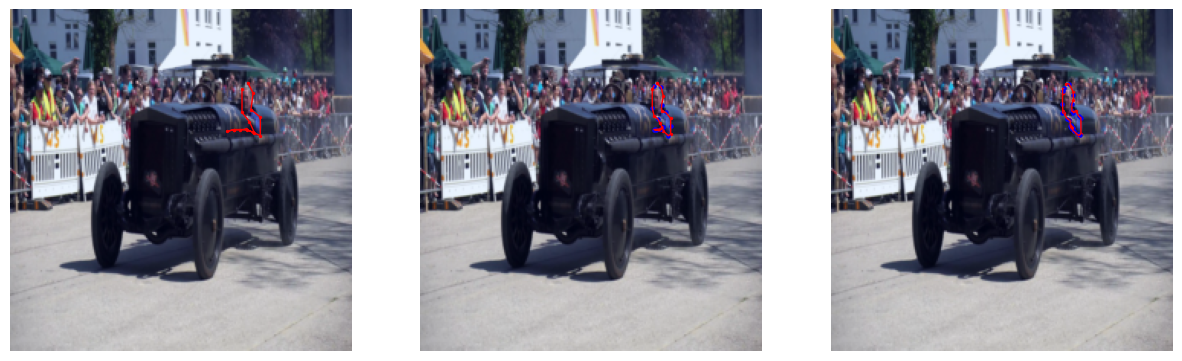

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(normalize(fir_img[0].permute(1, 2, 0)))
plt.axis("off")
bou = fir_points_set[2][0].numpy()
plt.plot(bou[:, 0], bou[:, 1], "r", linewidth=1)
plt.scatter(bou[:, 0], bou[:, 1], c="r", s=2)
plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(normalize(fir_img[0].permute(1, 2, 0)))
bou = fir_points_set[3][0].numpy()
plt.plot(bou[:, 0], bou[:, 1], "r", linewidth=1)
plt.scatter(bou[:, 0], bou[:, 1], c="r", s=2)
new_bou = bou[::2]
plt.scatter(new_bou[:, 0], new_bou[:, 1], c="b", s=5)
plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(normalize(fir_img[0].permute(1, 2, 0)))
bou = fir_points_set[4][0].numpy()
new_bou = bou[::2]
plt.plot(bou[:, 0], bou[:, 1], "r", linewidth=1)
plt.scatter(bou[:, 0], bou[:, 1], c="r", s=2)
plt.scatter(new_bou[:, 0], new_bou[:, 1], c="b", s=5)

In [9]:
fir_points_set

[tensor([[[ 92.0000,   0.0000],
          [ 74.0000, 213.0000],
          [191.0000, 153.0000],
          [ 93.0000,   0.0000]],
 
         [[ 67.6460,  91.0054],
          [102.2741, 123.1542],
          [152.6423, 124.4029],
          [147.3952,  79.8682]]]),
 tensor([[[133.5449,   0.0000],
          [ 88.6018,   0.0000],
          [ 76.3789, 114.3900],
          [ 70.8493, 224.0000],
          [135.1031, 224.0000],
          [200.5764, 224.0000],
          [167.4804, 107.6988],
          [178.8485,   0.0000]],
 
         [[ 94.1205,  83.0977],
          [ 68.5239,  93.9297],
          [ 86.3057, 110.6544],
          [110.0606, 122.3114],
          [134.5933, 125.5569],
          [152.4593, 114.8405],
          [147.9026,  87.1313],
          [121.5127,  86.6061]]]),
 tensor([[[153.2112,   0.0000],
          [132.0726,   0.0000],
          [110.9432,   0.0000],
          [ 89.8234,   0.0000],
          [ 84.8685,  54.9739],
          [ 77.9771, 109.7226],
          [ 72.5996, 164.905

In [10]:
fir_points_set[-1].shape

torch.Size([2, 64, 2])

In [11]:
tmp_points_set = []
for points in fir_points_set:
    tmp_points_set.append(points / 224)
tmp_points_set

[tensor([[[0.4107, 0.0000],
          [0.3304, 0.9509],
          [0.8527, 0.6830],
          [0.4152, 0.0000]],
 
         [[0.3020, 0.4063],
          [0.4566, 0.5498],
          [0.6814, 0.5554],
          [0.6580, 0.3566]]]),
 tensor([[[0.5962, 0.0000],
          [0.3955, 0.0000],
          [0.3410, 0.5107],
          [0.3163, 1.0000],
          [0.6031, 1.0000],
          [0.8954, 1.0000],
          [0.7477, 0.4808],
          [0.7984, 0.0000]],
 
         [[0.4202, 0.3710],
          [0.3059, 0.4193],
          [0.3853, 0.4940],
          [0.4913, 0.5460],
          [0.6009, 0.5605],
          [0.6806, 0.5127],
          [0.6603, 0.3890],
          [0.5425, 0.3866]]]),
 tensor([[[0.6840, 0.0000],
          [0.5896, 0.0000],
          [0.4953, 0.0000],
          [0.4010, 0.0000],
          [0.3789, 0.2454],
          [0.3481, 0.4898],
          [0.3241, 0.7362],
          [0.3344, 1.0000],
          [0.4443, 1.0000],
          [0.5542, 1.0000],
          [0.6640, 1.0000],
        

In [51]:
torch.zeros(1, 2).dtype, nn.Embedding(2, 2).weight.dtype

(torch.float32, torch.float32)

In [36]:



class DefInitVideo(nn.Module):
    def __init__(
        self,
        layer_num=1,
        up_scale_num=4,
        head_num=6,
        medium_level_size=[14, 28, 56, 112],
        offset_limit=10,
        n_points=4,
        mem_point_num=64,
        freeze_backbone=True,
    ):
        super(DefInitVideo, self).__init__()
        self.up_scale_num = up_scale_num
        self.offset_limit = offset_limit
        self.medium_level_size = medium_level_size
        self.featup = torch.hub.load(
            "mhamilton723/FeatUp",
            "dino16",
            use_norm=True,
        ).cuda()
        if freeze_backbone:
            for param in self.featup.parameters():
                param.requires_grad = False
        d_model = 384
        d_ffn = 1024
        n_levels = len(medium_level_size) + 1
        self.pos_enoc = PositionalEncoding(d_model)

        enc_layer = DeformableTransformerEncoderLayer(
            d_model=d_model,
            d_ffn=d_ffn,
            n_levels=n_levels,
            n_heads=head_num,
            n_points=n_points,
        )
        dec_layer = DeformableTransformerDecoderLayer(
            d_model=d_model,
            d_ffn=d_ffn,
            n_levels=n_levels,
            n_heads=head_num,
            n_points=n_points,
        )

        self.first_query_embed = nn.Embedding(mem_point_num, d_model)
        xavier_uniform_(self.first_query_embed.weight)
        self.first_layer_norm = nn.LayerNorm(d_model)
        self.fir_enc = DeformableTransformerEncoder(
            enc_layer,
            num_layers=layer_num,
        )
        self.fir_dec = DeformableTransformerDecoder(
            dec_layer,
            num_layers=layer_num,
        )
        self.previous_query_embed = nn.Embedding(mem_point_num, d_model)
        xavier_uniform_(self.previous_query_embed.weight)
        self.previous_layer_norm = nn.LayerNorm(d_model)
        self.pre_enc = DeformableTransformerEncoder(
            enc_layer,
            num_layers=layer_num,
        )
        self.pre_dec = DeformableTransformerDecoder(
            dec_layer,
            num_layers=layer_num,
        )
        self.extra_layer_norm = nn.LayerNorm(d_model)

        query_num = 4
        for _ in range(up_scale_num):
            query_num *= 2
        self.current_query_embed = nn.Embedding(query_num, d_model)
        xavier_uniform_(self.current_query_embed.weight)
        self.current_layer_norm = nn.LayerNorm(d_model)
        self.cur_enc = DeformableTransformerEncoder(
            enc_layer,
            num_layers=layer_num,
        )
        extra_dec_layer = DeformableTransformerExtraDecoderLayer(
            d_model=d_model,
            d_ffn=d_ffn,
            n_levels=n_levels,
            n_heads=head_num,
            n_points=n_points,
        )
        extra_dec = DeformableTransformerExtraDecoder(
            extra_dec_layer,
            num_layers=layer_num,
        )
        self.extra_decs = _get_clones(extra_dec, up_scale_num + 1)
        xy_fc = MLP(d_model, d_model, 2, 3)
        self.xy_fcs = _get_clones(xy_fc, up_scale_num + 1)

    def forward(
        self,
        fir_img: torch.Tensor,
        fir_bou: torch.Tensor,
        pre_img: torch.Tensor,
        pre_bou_set: list[torch.Tensor],
        cur_img: torch.Tensor,
    ):
        tmp_bou_set = []
        for bou in pre_bou_set:
            tmp_bou_set.append(bou.cuda() / 224)
        pre_bou_set = tmp_bou_set
        fir_bou = fir_bou / 224

        (
            fir_img_srcs_flatten,
            fir_spatial_shapes,
            fir_level_start_index,
            fir_valid_ratios,
        ) = self._get_enced_img_scrs(
            fir_img,
            self.fir_enc,
            self.first_layer_norm,
        )
        (
            pre_img_srcs_flatten,
            pre_spatial_shapes,
            pre_level_start_index,
            pre_valid_ratios,
        ) = self._get_enced_img_scrs(
            pre_img,
            self.pre_enc,
            self.previous_layer_norm,
        )
        (
            cur_img_srcs_flatten,
            cur_spatial_shapes,
            cur_level_start_index,
            cur_valid_ratios,
        ) = self._get_enced_img_scrs(
            cur_img,
            self.cur_enc,
            self.current_layer_norm,
        )

        B, S, C = fir_img_srcs_flatten.shape
        first_queries = (
            self.first_query_embed.weight.unsqueeze(0).repeat(B, 1, 1).cuda()
        )
        first_memory, _ = self.fir_dec(
            first_queries,
            fir_bou,
            fir_img_srcs_flatten,
            fir_spatial_shapes,
            fir_level_start_index,
            fir_valid_ratios,
        )
        previous_queries = (
            self.previous_query_embed.weight.unsqueeze(0).repeat(B, 1, 1).cuda()
        )
        previous_memory, _ = self.pre_dec(
            previous_queries,
            pre_bou_set[-1],
            pre_img_srcs_flatten,
            pre_spatial_shapes,
            pre_level_start_index,
            pre_valid_ratios,
        )
        extra_memory = torch.cat([first_memory, previous_memory], 1)
        extra_memory = self.extra_layer_norm(extra_memory)
        extra_memory = self.pos_enoc(extra_memory)

        cur_queries = (
            self.current_query_embed.weight.unsqueeze(0).repeat(B, 1, 1).cuda()
        )
        init_bou = pre_bou_set[0]
        current_query_num = init_bou.shape[1]
        current_query = cur_queries[:, :current_query_num]
        decode_output, _ = self.extra_decs[0](
            current_query,
            init_bou,
            cur_img_srcs_flatten,
            cur_spatial_shapes,
            cur_level_start_index,
            cur_valid_ratios,
            extra_memory,
        )

        xy_offset = (
            (self.xy_fcs[0](decode_output).sigmoid() - 0.5) * self.offset_limit / 224
        )
        init_bou += xy_offset

        results = [init_bou]
        for i in range(self.up_scale_num):
            new_query = cur_queries[:, current_query_num : current_query_num * 2]
            current_query_num *= 2

            current_query = torch.zeros((B, current_query_num, C)).to(
                cur_img_srcs_flatten.device
            )
            current_query[:, ::2] = new_query
            current_query[:, 1::2] = decode_output

            new_bou = torch.zeros((B, current_query_num, 2)).to(
                cur_img_srcs_flatten.device
            )
            new_bou[:, 1::2] = results[-1]
            new_points = pre_bou_set[i + 1][:, ::2]
            # print(new_points.shape)
            # print(new_bou.shape)
            # print(new_bou[:, ::2].shape)
            new_bou[:, ::2] = new_points

            cur_bou = new_bou
            decode_output, _ = self.extra_decs[i + 1](
                current_query,
                cur_bou,
                cur_img_srcs_flatten,
                cur_spatial_shapes,
                cur_level_start_index,
                cur_valid_ratios,
                extra_memory,
            )

            xy_offset = (
                (self.xy_fcs[i + 1](decode_output).sigmoid() - 0.5)
                * self.offset_limit
                / 224
            )
            cur_bou += xy_offset

            results.append(cur_bou)
        results = [result * 224 for result in results]

        if not self.training:
            results = [result.clamp(0, 223) for result in results]

        return results

    def _get_img_scrs(self, img: torch.Tensor, layernorm: nn.LayerNorm):
        feats = self.featup(img)
        srcs = []
        padding_masks = []
        for low_res in self.medium_level_size:
            srcs.append(
                F.interpolate(
                    feats,
                    size=(low_res, low_res),
                    mode="bilinear",
                ),
            )
        srcs.append(feats)
        for src in srcs:
            padding_masks.append(torch.zeros_like(src[:, 0:1, :, :]).squeeze(1).bool())
        src_flatten = []
        spatial_shapes = []
        for src in srcs:
            src_flatten.append(
                rearrange(src, "b c h w -> b (h w) c"),
            )
            spatial_shapes.append(src.shape[-2:])
        level_start_index = torch.cat(
            (
                torch.tensor([0]),
                torch.cumsum(
                    torch.tensor([x.shape[1] for x in src_flatten]),
                    0,
                )[:-1],
            )
        ).cuda()
        src_flatten = torch.cat(src_flatten, 1).cuda()
        valid_ratios = torch.stack(
            [get_valid_ratio(mask) for mask in padding_masks],
            1,
        ).cuda()
        spatial_shapes = torch.as_tensor(
            spatial_shapes,
            dtype=torch.long,
            device=src_flatten.device,
        )
        src_flatten = layernorm(src_flatten)
        src_flatten = self.pos_enoc(src_flatten)
        return src_flatten, spatial_shapes, level_start_index, valid_ratios

    def _get_enced_img_scrs(
        self,
        img: torch.Tensor,
        encoder: DeformableTransformerEncoder,
        layernorm: nn.LayerNorm,
    ):
        src_flatten, spatial_shapes, level_start_index, valid_ratios = (
            self._get_img_scrs(img, layernorm)
        )
        src_flatten = encoder(
            src=src_flatten,
            spatial_shapes=spatial_shapes,
            level_start_index=level_start_index,
            valid_ratios=valid_ratios,
        )
        return src_flatten, spatial_shapes, level_start_index, valid_ratios

In [26]:
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [19]:
model = DefInitVideo().cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [20]:
results = model(
    fir_img.cuda(),
    fir_points_set[-1].cuda(),
    pre_img.cuda(),
    pre_points_set,
    cur_img.cuda(),
)

/work3/s232248/miniconda3/envs/rass/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538439764/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [34]:
results[-1].shape, len(results), len(fir_points_set), fir_points_set[-1].shape

(torch.Size([1, 64, 2]), 5, 5, torch.Size([1, 64, 2]))

In [19]:
short_train_rawset = copy.copy(train_rawset)
short_train_rawset.data_set = train_rawset.data_set[:5]
short_train_dataset = DAVIS_withPointSet(
    short_train_rawset,
    is_train=True,
)
len(short_train_dataset.raw_data_set)

3

In [20]:
short_val_rawset = copy.copy(val_rawset)
short_val_rawset.data_set = val_rawset.data_set[:2]
short_val_dataset = DAVIS_withPointSet(
    short_val_rawset,
    is_train=False,
)
len(short_val_dataset.raw_data_set)

2

In [28]:
short_loader = DataLoader(short_train_dataset, batch_size=1, shuffle=True)

In [25]:
gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()
ras_loss = RasLoss().cuda()

In [36]:
model = DefInitVideo().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loss_dict = {}
train_iou_dict = {}
epoch_num = 4

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [37]:
for e in range(epoch_num):
    mean_loss = 0
    train_mean_iou = 0
    model.train()
    for (
        video_idx,
        frame_idx,
        first_frame,
        previous_frame,
        current_frame,
    ) in tqdm(short_loader):
        optimizer.zero_grad()
        fir_img, fir_mask, fir_points_set = first_frame
        pre_img, pre_mask, pre_points_set = previous_frame
        cur_img, cur_mask, cur_points_set = current_frame
        pre_points_set = [points.cuda() for points in pre_points_set]
        results = model(
            fir_img.cuda(),
            fir_points_set[-1].cuda(),
            pre_img.cuda(),
            pre_points_set,
            cur_img.cuda(),
        )
        loss = 0
        for result in results:
            loss += ras_loss(result, cur_mask.cuda())
        loss /= len(results)
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
        iou = get_batch_average_bou_iou(
            results[-1],
            cur_mask.cuda(),
            gt_rasterizer,
        )
        train_mean_iou += iou
    mean_loss /= len(short_loader)
    train_mean_iou /= len(short_loader)
    train_loss_dict[e] = mean_loss
    train_iou_dict[e] = train_mean_iou
    print(f"Epoch {e}, loss: {mean_loss:.4f}, iou: {train_mean_iou:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [01:25<00:00,  2.82it/s]


Epoch 0, loss: 0.1728, iou: 0.7658


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [01:25<00:00,  2.82it/s]


Epoch 1, loss: 0.1570, iou: 0.7942


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [01:25<00:00,  2.82it/s]


Epoch 2, loss: 0.1527, iou: 0.8022


  8%|███████████▋                                                                                                                                 | 20/241 [00:07<01:19,  2.77it/s]


KeyboardInterrupt: 

In [40]:
img, mask, points_set = val_point_set.raw_data_set[0][0]
img.shape, mask.shape, len(points_set), points_set[0].shape

(torch.Size([3, 224, 224]), torch.Size([224, 224]), 5, torch.Size([4, 2]))

In [21]:
class InitVideoInferer:
    def __init__(
        self,
        dataset: DAVIS_withPointSet,
        gt_rasterizer: SoftPolygon,
    ) -> None:
        self.dataset = dataset.raw_data_set
        self.gt_rasterizer = gt_rasterizer

    def infer_one_video(self, video_idx: int, model: nn.Module):
        infer_results = []
        video_data = self.dataset[video_idx]
        model.eval()

        def get_batch_data(frame_data: tuple):
            img, mask, points_set = frame_data
            img = img.unsqueeze(0)
            mask = mask.unsqueeze(0)
            points_set = [points.unsqueeze(0) for points in points_set]
            return img, mask, points_set

        fir_img, fir_mask, fir_points_set = get_batch_data(video_data[0])
        pre_img, pre_mask, pre_points_set = get_batch_data(video_data[0])
        infer_results.append(None)
        with torch.no_grad():
            for i in range(1, len(video_data)):
                cur_img, cur_mask, cur_points_set = get_batch_data(video_data[i])
                pred_bous = model(
                    fir_img.cuda(),
                    fir_points_set[-1].cuda(),
                    pre_img.cuda(),
                    pre_points_set,
                    cur_img.cuda(),
                )
                pred_mask = self.gt_rasterizer(pred_bous[-1], 224, 224)
                pred_mask[pred_mask == -1] = 0
                iou = get_batch_average_bou_iou(
                    pred_bous[-1],
                    cur_mask.cuda(),
                    self.gt_rasterizer,
                )
                infer_results.append((pred_bous, pred_mask, iou.item()))
                pre_img, pre_mask, pre_points_set = cur_img, pred_mask, pred_bous
        return infer_results
    
    def infer_all_videos(self, model: nn.Module, use_tqdm=False):
        self.infer_results = []
        if use_tqdm:
            video_range = tqdm(range(len(self.dataset)))
        else:
            video_range = range(len(self.dataset))
        for video_idx in video_range:
            self.infer_results.append(self.infer_one_video(video_idx, model))
    
    def compute_video_iou(self, video_idx: int):
        infer_results = self.infer_results[video_idx]
        ious = [result[-1] for result in infer_results[1:]]
        return np.mean(ious)

    def compute_all_iou(self):
        self.video_ious = []
        for video_idx in range(len(self.dataset)):
            self.video_ious.append(self.compute_video_iou(video_idx))
        return np.mean(self.video_ious)

    def show_video_results(
        self,
        video_idx: int,
        mask_alpha=0.2,
        img_per_row=5,
    ):
        video_data = self.dataset[video_idx]
        pred_results = self.infer_results[video_idx]
        frame_num = len(video_data)
        line_num = frame_num // img_per_row + 1
        plt.figure(figsize=(20, 4 * line_num))
        for i, pred_data in enumerate(pred_results):
            plt.subplot(line_num, img_per_row, i + 1)
            cur_img, cur_mask, cur_points = video_data[i]
            cur_point = cur_points[-1]
            plt.imshow(normalize(cur_img).permute(1, 2, 0))
            plt.imshow(cur_mask, alpha=mask_alpha)
            if pred_data is None:
                plt.title("ground truth")
                plt.axis("off")
                plt.plot(cur_point[:, 0], cur_point[:, 1], "r")
                plt.scatter(cur_point[:, 0], cur_point[:, 1], c="r", s=5)
            else:
                pred_bous, pred_mask, iou = pred_data
                pred_bou = pred_bous[-1]
                plt.title(f"iou: {iou:.4f}")
                plt.axis("off")
                pred_bou = pred_bou[0].detach().cpu().numpy()
                plt.plot(pred_bou[:, 0], pred_bou[:, 1], "r")
                plt.scatter(pred_bou[:, 0], pred_bou[:, 1], c="r", s=5)

In [59]:
video_inferer = InitVideoInferer(short_train_dataset, gt_rasterizer)

In [60]:
video_inferer.infer_all_videos(model, use_tqdm=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:42<00:00, 14.15s/it]


In [61]:
video_inferer.compute_all_iou()

0.36447176347913435

In [ ]:
video_inferer.show_video_results(0)

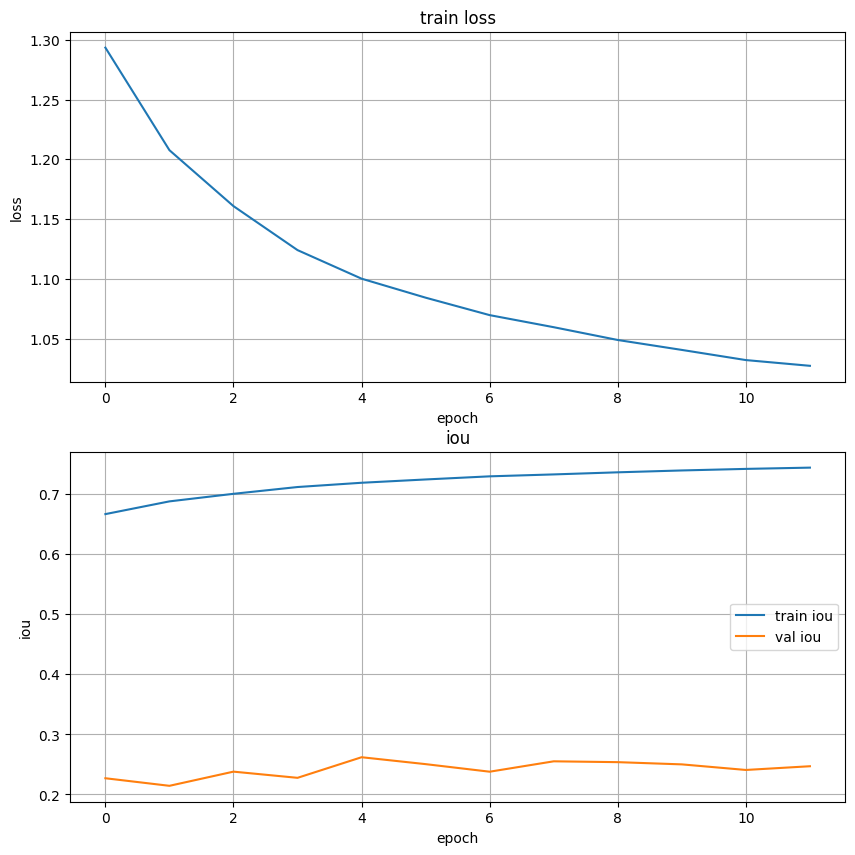

In [56]:
# load and eval
model_name = "def_init"
log_dir = f"./log/{model_name}"
log_path = f"{log_dir}/{model_name}.log"
model_path = f"./model/{model_name}_best.pth"
# load the log
with open(log_path, "r") as f:
    logs = f.readlines()
loss_dict = {}
iou_train_dict = {}
iou_val_dict = {}
# get the loss and iou using regex
for log in logs:
    # get the epoch
    epoch = re.search(r"Epoch (\d+)", log)
    if epoch is not None:
        epoch = int(epoch.group(1))
        # get the loss
        loss = re.search(r"train loss: ([\d.]+)", log)
        if loss is not None:
            loss_dict[epoch] = float(loss.group(1))
        # get the train iou
        iou = re.search(r"train mean iou: ([\d.]+)", log)
        if iou is not None:
            iou_train_dict[epoch] = float(iou.group(1))
        # get the val iou
        iou = re.search(r"val mean iou: ([\d.]+)", log)
        if iou is not None:
            iou_val_dict[epoch] = float(iou.group(1))
# plot the loss and iou
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(loss_dict.keys(), loss_dict.values())
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("train loss")
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(iou_train_dict.keys(), iou_train_dict.values(), label="train iou")
plt.plot(iou_val_dict.keys(), iou_val_dict.values(), label="val iou")
plt.xlabel("epoch")
plt.ylabel("iou")
plt.title("iou")
plt.legend()
plt.show()

In [48]:
# load the model
model = DefInitVideo(offset_limit=10).cuda()
model.load_state_dict(torch.load(model_path))

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/tmp/ipykernel_3643384/3593775652.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please 

<All keys matched successfully>

In [49]:
val_inferer = InitVideoInferer(val_point_set, gt_rasterizer)

In [50]:
val_inferer.infer_all_videos(model, use_tqdm=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [10:39<00:00, 11.22s/it]


In [57]:
val_inferer.compute_all_iou()

0.2626823536018831

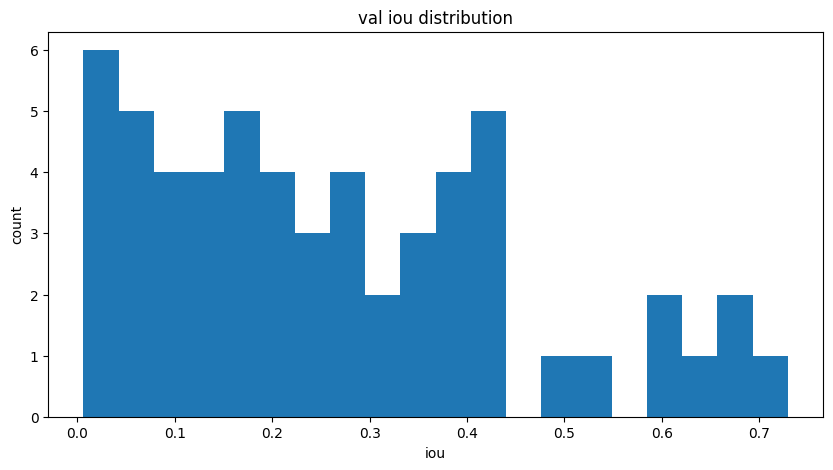

In [58]:
ious = []
for video_idx in range(len(val_inferer.dataset)):
    ious.append(val_inferer.compute_video_iou(video_idx))
# plot the distribution of iou
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20)
plt.xlabel("iou")
plt.ylabel("count")
plt.title("val iou distribution")
plt.show()

In [ ]:
val_check_idxs = [2, 7, 9, 10, 18, 24, 13, 41, 46, 50, 54, 39]
for idx in val_check_idxs:
    val_inferer.show_video_results(idx)